In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from xgboost import XGBRegressor
from xgboost import XGBClassifier
import shap
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.cross_decomposition import PLSRegression

import warnings
warnings.filterwarnings('ignore')

In [3]:
df_loan = pd.read_csv('D:/loan_data.csv')

In [4]:
df_loan.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [7]:
for column in df_loan.select_dtypes(include=['object']).columns:
    df_loan[column], unique = pd.factorize(df_loan[column])

In [9]:
y = df_loan['loan_status'].values
X = df_loan.drop(columns = ['loan_status']).values

In [10]:
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

In [11]:
X_d = add_constant(df_loan.drop('loan_status', axis=1))

In [12]:
VIFs = pd.DataFrame()
VIFs['Variable'] = X_d.columns
VIFs['VIF'] = [variance_inflation_factor(X_d.values, i) for i in range(X_d.shape[1])]
print(VIFs)

                          Variable         VIF
0                            const  382.243360
1                       person_age   14.132289
2                    person_gender    1.000545
3                 person_education    1.003795
4                    person_income    1.443599
5                   person_emp_exp   11.274260
6            person_home_ownership    1.149391
7                        loan_amnt    2.187334
8                      loan_intent    1.003653
9                    loan_int_rate    1.075111
10             loan_percent_income    2.202099
11      cb_person_cred_hist_length    3.927744
12                    credit_score    1.074801
13  previous_loan_defaults_on_file    1.128951


In [13]:
high_vif = VIFs[VIFs['VIF'] > 5]  
X_d = X_d.drop(columns=high_vif['Variable'])

In [14]:
pls = PLSRegression(n_components=3)
pls.fit(X, y)

PLSRegression(n_components=3)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_d, y, test_size = 0.2, random_state = 42)

In [27]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [39]:
lda = LDA(n_components=1)
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)

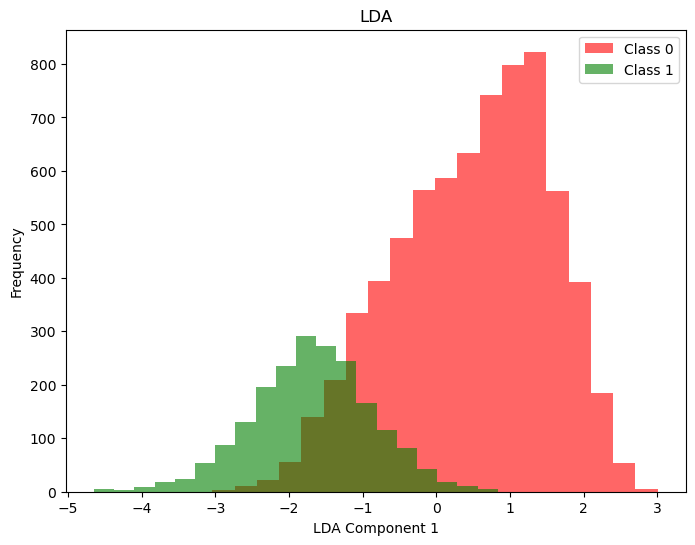

In [46]:
plt.figure(figsize=(8, 6))
for label, color in zip(range(2), ('red', 'green')):
    plt.hist(X_test_lda[y_test == label, 0], color=color, alpha=0.6, bins=20)
plt.xlabel('LDA Component 1')
plt.ylabel('Frequency')
plt.title('LDA')
plt.legend(['Class 0', 'Class 1'])
plt.show()

In [ ]:
lr = LogisticRegression()
lr.fit(X_train_lda, y_train)
y_pred = lr.predict(X_test_lda)
print(f"LDA-based Logistic Regression Accuracy: {accuracy_score(y_test, y_pred):.2f}")

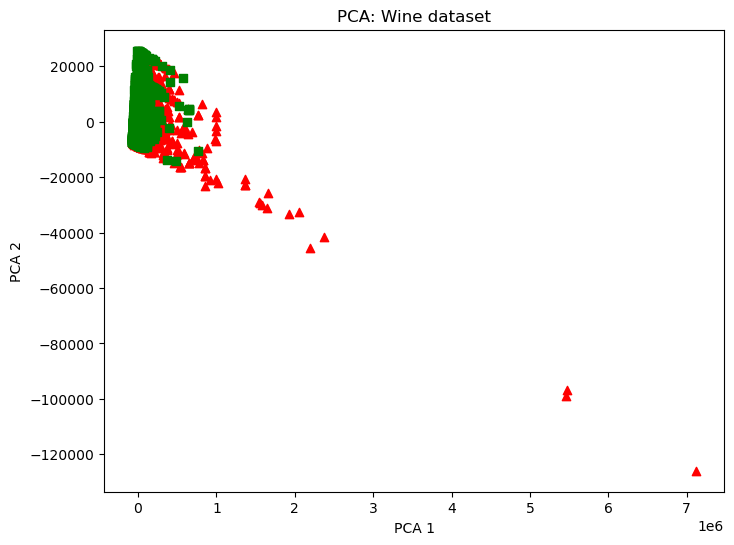

In [25]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

plt.figure(figsize=(8, 6))
for label, marker, color in zip(range(2), ('^', 's'), ('red', 'green')):
    plt.scatter(X_train_pca[y_train == label, 0],
                X_train_pca[y_train == label, 1],
                marker=marker, color=color)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA: Wine dataset')
plt.show()

In [28]:
lr_pca = LogisticRegression()
lr_pca.fit(X_train_pca, y_train)
y_pred_pca = lr_pca.predict(X_test_pca)
print(f"PCA-based Logistic Regression Accuracy: {accuracy_score(y_test, y_pred_pca):.2f}")


PCA-based Logistic Regression Accuracy: 0.79


In [32]:
model = XGBClassifier(objective='reg:squarederror', random_state=4)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [33]:
y_pred = model.predict(X_test)

In [34]:
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

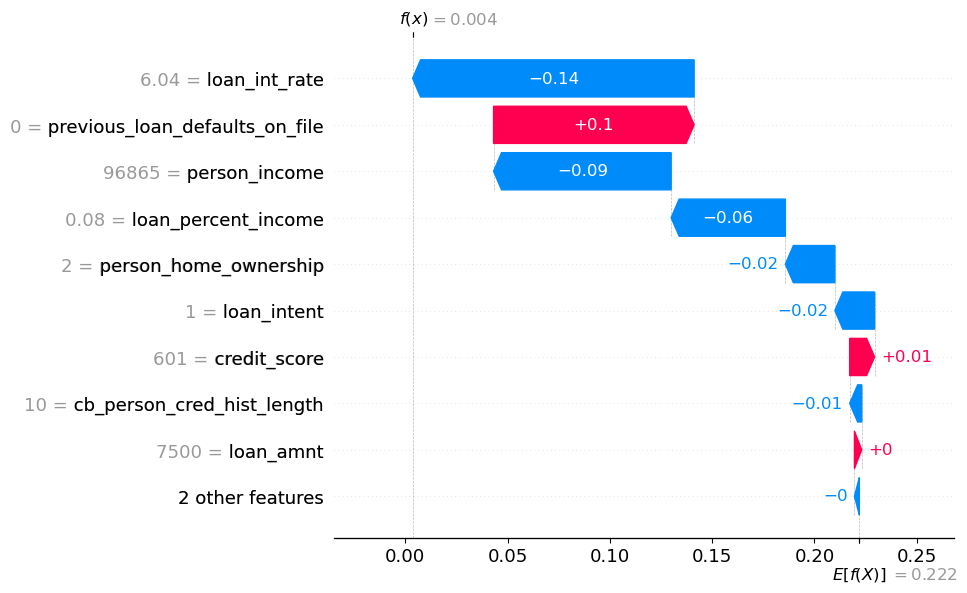

In [35]:
shap.plots.waterfall(shap_values[0])

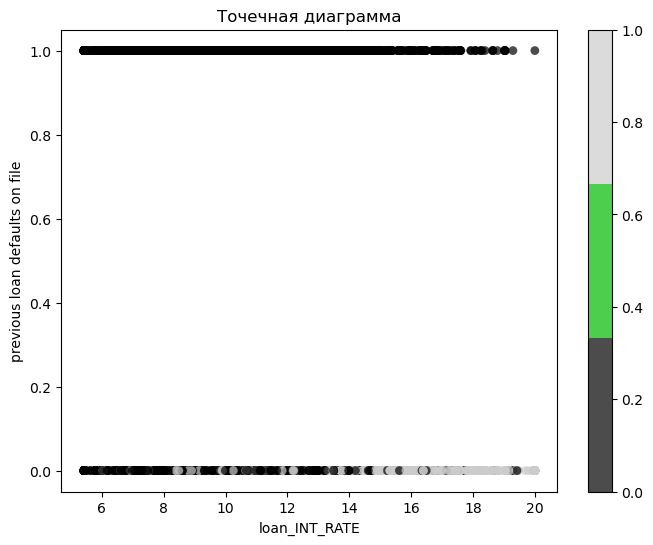

In [44]:
feature_x = X_test['loan_int_rate']
feature_y = X_test['previous_loan_defaults_on_file']
price =  y_pred

# Создание точечной диаграммы
plt.figure(figsize=(8,6))
plt.scatter(feature_x, feature_y, c=price, edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 3))
plt.colorbar()
plt.xlabel("loan_INT_RATE")
plt.ylabel("previous loan defaults on file")
plt.title("Точечная диаграмма")
plt.show()